# Objective
* 20190208: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Here we use last value to do prediction
* 20190213:
    * Instead of using last value method, we use prophet package to predict
* 20190301:
    * Instead of using prophet, we use single exponential smoothing to predict

In [116]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from collections import defaultdict
from datetime import date, datetime, time, timedelta
from fbprophet import Prophet
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
# H_list = [1, 21, 42, 63]        # Forecast horizon we will be testing, in days. Note there are about 21 trading days in a year
H_list = [21]
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

alphaMax = 0.999                # alpha is a hyperparameter to tune
alphaMin = 0.05                 # alpha is a hyperparameter to tune
alphaStep = 0.05               # alpha is a hyperparameter to tune

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [117]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [118]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def exponential_smoothing(series, alpha, H):
    """
    Given a series and alpha, return series of smoothed points
    Set S_2 = y_1 (there is no S_1), and
    S_t = alpha * y_t-1 + (1-alpha) * S_t-1, where t >= 3. Note t starts from 1.
    Forecast S_t+1 = alpha * y_origin + (1-alpha) * S_t, where y_origin is the last known data point    
    Inputs
        series: series to forecast
        alpha : smoothing constant. 
                When alpha is close to 1, dampening is quick. 
                When alpha is close to 0, dampening is slow
        H     : forecast horizon
    Outputs
        result: original series + the predictions. The length of result is len(series) + H, where H >= 1
    """
    result = [0, series[0]] # initialization
    for n in range(1, len(series)+H-1):
        if n >= len(series): # we are forecasting
            result.append(alpha * series[-1] + (1 - alpha) * result[n])
        else:
            result.append(alpha * series[n] + (1 - alpha) * result[n]) 
            # result[2] is the forecast using series[1],  ie. result[2] is the estimate of series[2]
    return result
    
def tune_alpha(series, train_size, H):
    """
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        H          : forecast horizon
    Outputs
        result: original series + the predictions. The length of result is len(series) + H, where H >= 1
    """
    alpha_err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        preds_list = exponential_smoothing(series[:train_size], alpha, H)
        
        # Append alpha
        alpha_err_dict['alpha'].append(alpha)
    
        # Compute error metrics
        alpha_err_dict['rmse'].append(get_rmse(series[train_size:train_size+H], preds_list[train_size:]))
        alpha_err_dict['mape'].append(get_mape(series[train_size:train_size+H], preds_list[train_size:]))
        alpha_err_dict['mae'].append(get_mae(series[train_size:train_size+H], preds_list[train_size:]))
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    alpha_err_df = pd.DataFrame(alpha_err_dict)
    
    # Get min RMSE
    rmse_min = alpha_err_df['rmse'].min()
    
    # stop here
    return (alpha_err_min[alpha_err_df['rmse'] == rmse_min]['alpha'], rmse_min)

# Load data

In [119]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [120]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

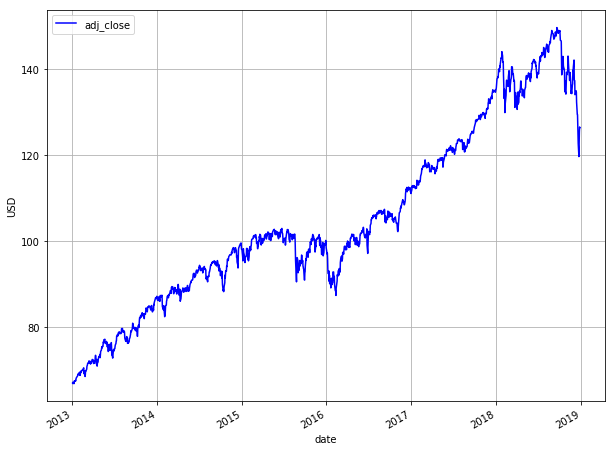

In [121]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Single Exponential Smoothing, for a specific H (forecast horizon)

In [122]:
# Predict using Prophet, and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
alpha = 0.1 # smoothing constant
for i in tqdm_notebook(range(train_val_size+1, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df['date'][i]))
    
    preds_list = exponential_smoothing(df['adj_close'][i-train_val_size:i].values, alpha, H)
    
    # Collect the predictions
    preds_dict[i] = preds_list[train_val_size:]
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['adj_close'], preds_list[train_val_size:]))
    mape.append(get_mape(df[i:i+H]['adj_close'], preds_list[train_val_size:]))
    mae.append(get_mae(df[i:i+H]['adj_close'], preds_list[train_val_size:]))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

A Jupyter Widget

Predicting on day 1009, date 2017-01-04 00:00:00
Predicting on day 1019, date 2017-01-19 00:00:00
Predicting on day 1029, date 2017-02-02 00:00:00
Predicting on day 1039, date 2017-02-16 00:00:00
Predicting on day 1049, date 2017-03-03 00:00:00
Predicting on day 1059, date 2017-03-17 00:00:00
Predicting on day 1069, date 2017-03-31 00:00:00
Predicting on day 1079, date 2017-04-17 00:00:00
Predicting on day 1089, date 2017-05-01 00:00:00
Predicting on day 1099, date 2017-05-15 00:00:00
Predicting on day 1109, date 2017-05-30 00:00:00
Predicting on day 1119, date 2017-06-13 00:00:00
Predicting on day 1129, date 2017-06-27 00:00:00
Predicting on day 1139, date 2017-07-12 00:00:00
Predicting on day 1149, date 2017-07-26 00:00:00
Predicting on day 1159, date 2017-08-09 00:00:00
Predicting on day 1169, date 2017-08-23 00:00:00
Predicting on day 1179, date 2017-09-07 00:00:00
Predicting on day 1189, date 2017-09-21 00:00:00
Predicting on day 1199, date 2017-10-05 00:00:00
Predicting on day 12

In [123]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 2.626327
For forecast horizon 21, the mean MAPE is 1.751745
For forecast horizon 21, the mean MAE is 2.328196


Text(0, 0.5, 'USD')

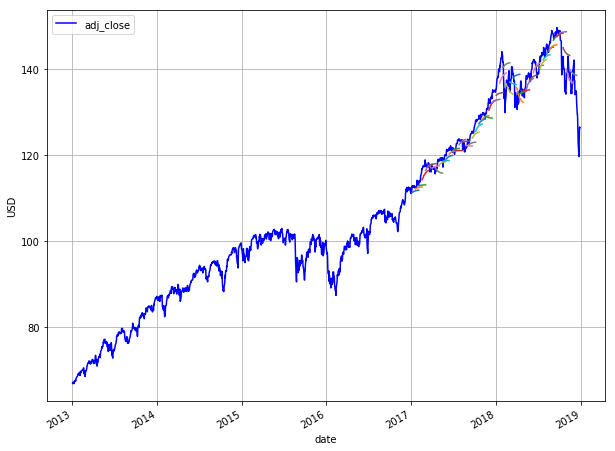

In [124]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")

(736330.0, 736663.0)

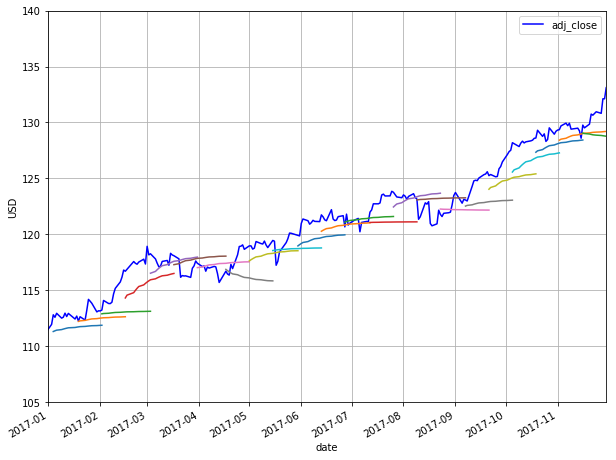

In [125]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([105, 140])
ax.set_xlim([date(2017, 1, 1), date(2017, 11, 30)])

# Predict using Single Exponential Smoothing, for various H (forecast horizon)

In [126]:
rmse_list = [] # rmse for each H in H_list
mape_list = [] # mape for each H in H_list
mae_list = []  # mae for each H in H_list

for H in tqdm_notebook(H_list):
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error

    for i in tqdm_notebook(range(train_val_size+1, len(df)-H, max(1, int(H/2)))): # Do a forecast on day i
#         print("Predicting on day %d, date %s" % (i, df['date'][i]))

        alpha_err_df = tune_alpha(df['adj_close'][i-train_val_size:i].values, train_size, H)
        print(alpha_err_df)
#         preds_list = exponential_smoothing(df['adj_close'][i-train_val_size:i].values, alpha, H)
    
#         # Compute error metrics
#         rmse.append(get_rmse(df[i:i+H]['adj_close'], preds_list[train_val_size:]))
#         mape.append(get_mape(df[i:i+H]['adj_close'], preds_list[train_val_size:]))
#         mae.append(get_mae(df[i:i+H]['adj_close'], preds_list[train_val_size:]))
        
#     rmse_list.append(np.mean(rmse))
#     mape_list.append(np.mean(mape))
#     mae_list.append(np.mean(mae))

A Jupyter Widget

A Jupyter Widget

    alpha      rmse      mape       mae
0    0.05  6.632872  7.002942  6.390298
1    0.10  6.185372  6.521859  5.950843
2    0.15  5.933848  6.246449  5.698618
3    0.20  5.800937  6.098695  5.563071
4    0.25  5.721721  6.006692  5.478378
5    0.30  5.670395  5.942338  5.418833
6    0.35  5.635555  5.894035  5.373880
7    0.40  5.611302  5.856293  5.338558
8    0.45  5.594197  5.826114  5.310167
9    0.50  5.582069  5.801643  5.287039
10   0.55  5.573476  5.781619  5.268037
11   0.60  5.567428  5.765129  5.252330
12   0.65  5.563223  5.751483  5.239288
13   0.70  5.560357  5.740147  5.228419
14   0.75  5.558464  5.730700  5.219337
15   0.80  5.557274  5.722806  5.211728
16   0.85  5.556585  5.716197  5.205343
17   0.90  5.556251  5.716489  5.205649
18   0.95  5.556161  5.719805  5.208884
    alpha      rmse      mape       mae
0    0.05  4.020001  3.965667  3.561708
1    0.10  2.390311  2.185425  1.960950
2    0.15  1.848831  1.761260  1.586281
3    0.20  1.679355  1.574641  1.421493


    alpha      rmse      mape       mae
0    0.05  1.238710  1.075563  1.140261
1    0.10  1.226692  0.883590  0.930606
2    0.15  1.266472  0.893597  0.940357
3    0.20  1.277453  0.906012  0.953377
4    0.25  1.280861  0.910363  0.957949
5    0.30  1.282103  0.912646  0.960358
6    0.35  1.282621  0.914125  0.961925
7    0.40  1.282861  0.914851  0.962695
8    0.45  1.282981  0.915215  0.963080
9    0.50  1.283041  0.915391  0.963266
10   0.55  1.283071  0.915469  0.963348
11   0.60  1.283084  0.915493  0.963373
12   0.65  1.283088  0.915491  0.963370
13   0.70  1.283087  0.915481  0.963358
14   0.75  1.283086  0.915470  0.963347
15   0.80  1.283085  0.915463  0.963340
16   0.85  1.283085  0.915459  0.963335
17   0.90  1.283083  0.915452  0.963327
18   0.95  1.283079  0.915432  0.963306
    alpha      rmse      mape       mae
0    0.05  1.033482  0.815432  0.860400
1    0.10  1.449948  1.199287  1.263732
2    0.15  1.556460  1.291552  1.360881
3    0.20  1.603673  1.329467  1.400763


In [127]:
alpha_err_df

,alpha,rmse,mape,mae
0,0.05,3.327433,2.320355,3.069062
1,0.10,2.728174,1.778358,2.356620
2,0.15,2.655191,1.704477,2.259413
3,0.20,2.644434,1.693909,2.245447
4,0.25,2.643304,1.692791,2.243951
5,0.30,2.643593,1.693336,2.244654
6,0.35,2.643873,1.693849,2.245326
7,0.40,2.643979,1.694037,2.245576
8,0.45,2.643966,1.693954,2.245474
9,0.50,2.643901,1.693716,2.245170


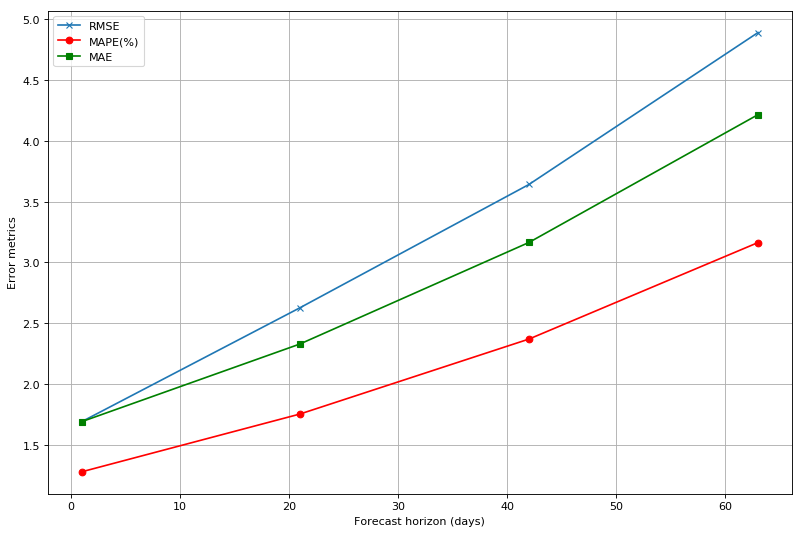

In [52]:
# Plot the error metrics for various forecast horizons
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(H_list, rmse_list, 'x-')
plt.plot(H_list, mape_list, 'ro-')
plt.plot(H_list, mae_list, 'gs-')
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Error metrics')
plt.legend(['RMSE', 'MAPE(%)', 'MAE'], loc = 'upper left')
plt.grid()

matplotlib.rcParams.update({'font.size': 14})

# Findings
* The larger the forecast horizon, the larger the error
* Lowest RMSE, MAPE and MAE is achieved at forecast horizon H = 1